# <center>Data Analytics laboratory </center>

## <center>Linear models - modelling height of !Kung people</center>

In [2]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


### Task 1

In [4]:
%%writefile height_1_ppc.stan


data {
  int<lower=0> N; // number of observations
}

parameters {
  real mu; // mean height
  real<lower=0> sigma; // standard deviation of height
}

model {
  mu ~ normal(165, 10); // reasonable mean height
  sigma ~ normal(15, 5); // reasonable prior for standard deviation
}

generated quantities {
  real height_sim;
  height_sim = normal_rng(mu, sigma); // simulate height measurement
}


Overwriting height_1_ppc.stan


INFO:cmdstanpy:compiling stan file /height_1_ppc.stan to exe file /height_1_ppc
INFO:cmdstanpy:compiled model executable: /height_1_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.



       lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0  2.695570       0.974821     0.41776          2.0           7.0   
1  2.472660       0.944563     0.41776          2.0           7.0   
2  1.711550       0.176568     0.41776          2.0           3.0   
3  1.633370       0.990752     0.41776          3.0           7.0   
4  0.394806       0.980179     0.41776          2.0           3.0   

   divergent__  energy__       mu     sigma  height_sim  
0          0.0 -0.455263  162.008  15.60620     162.149  
1          0.0 -1.879610  168.694  19.68470     192.226  
2          0.0  0.237252  166.900   9.76146     172.872  
3          0.0 -1.304690  169.327   9.75306     185.541  
4          0.0 -0.223423  165.676   6.44006     169.891  
Simulated height measurement: 165.07 cm


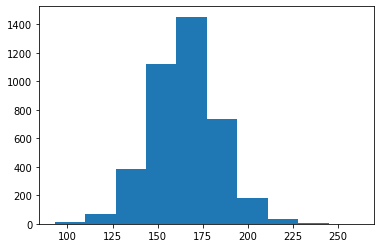

arviz - WARNING - Shape validation failed: input_shape: (1, 1), minimum_shape: (chains=1, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
heights,165.071,NaN,165.071,165.071,NaN,NaN,NaN,NaN,NaN


In [5]:
N = 100
model = CmdStanModel(stan_file='height_1_ppc.stan')

samples = model.sample(data={'N': N})
simulated_height = samples.stan_variable('height_sim').mean()
df = samples.draws_pd()
print(df.head())


print(f"Simulated height measurement: {simulated_height:.2f} cm")

# Plot the histogram of the generated heights
plt.hist(df['height_sim'])
plt.show()
az.summary({'heights': simulated_height})

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


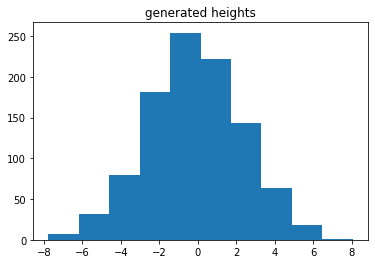

In [6]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(data={'N': N},
                     iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

df = sim.draws_pd()
# Plot the histogram of the generated heights
plt.hist(df['height_sim'])
plt.title("generated heights")
plt.show()

### Task 2

In [7]:
%%writefile height_1_fit.stan


data {
  int<lower=0> N;
  real<lower=0> heights[N];
}

parameters {
  real<lower=0> mu;
  real<lower=0> sigma;
}

model {
  mu ~ normal(165, 10);
  sigma ~ cauchy(0, 10);
  heights ~ normal(mu, sigma);
}

generated quantities {
  real height_prediction = normal_rng(mu, sigma);
}

Overwriting height_1_fit.stan


In [8]:
model = CmdStanModel(stan_file='height_1_fit.stan')
fit=model.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

mu = fit.draws_pd()['mu'].mean()
sigma = fit.draws_pd()['sigma'].mean()
height_prediction = np.random.normal(loc=mu.mean(), scale=sigma.mean())
print('Predicted height:', height_prediction)

INFO:cmdstanpy:compiling stan file /height_1_fit.stan to exe file /height_1_fit
INFO:cmdstanpy:compiled model executable: /height_1_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/height_1_fit.hpp /height_1_fit.stan
Warning in '/height_1_fit.stan', line 5, column 2: Declaration of arrays by
    placing brackets after a variable name is deprecated and will be removed
    in Stan 2.32.0. Instead use the array keyword before the type. This can
    be changed automatically using the auto-format flag to stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math/lib/sundials_6.0.0/include -I stan/lib/stan_math/lib/sundials_6.0.0/src/sundials    -DBOOST_DISABLE_ASSERTS          


INFO:cmdstanpy:CmdStan done processing.



Predicted height: 157.71970263336672


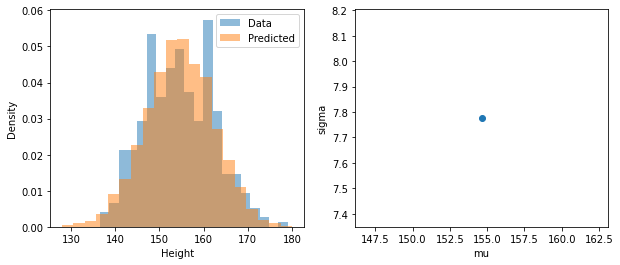

In [9]:
# Plots
plt.show()
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(d.height.values, bins=20, density=True, alpha=0.5, label='Data')
axs[0].hist(fit.draws_pd()["height_prediction"], bins=20, density=True, alpha=0.5, label='Predicted')
axs[0].set_xlabel('Height')
axs[0].set_ylabel('Density')
axs[0].legend()
axs[1].scatter(mu, sigma)
axs[1].set_xlabel('mu')
axs[1].set_ylabel('sigma')
plt.show()

### Task 3

In [50]:
d['c_weight'] = d['weight'] - d['weight'].mean()
data_sim = {'N':50, 'weight':np.linspace(d.weight.min(),d.weight.max())}
d.head()

,height,weight,age,male,c_weight
0,151.765,47.825606,63.0,1,2.835121
1,139.700,36.485807,63.0,0,-8.504679
2,136.525,31.864838,65.0,0,-13.125648
3,156.845,53.041914,41.0,1,8.051429
4,145.415,41.276872,51.0,0,-3.713614


### Task 4

In [75]:
%%writefile height_2a_ppc.stan

data {
   int N;
   real <lower=0> weight[N];
}

generated quantities {
   real sigma = normal_rng(0, 5);
   real alpha = normal_rng(165, 10);
   real beta = normal_rng(0, 1);

   real height[N];

   for (i in 1:N) 
   {
      height[i] = normal_rng(alpha + beta * weight[i], sigma);
   }
}

Overwriting height_2a_ppc.stan


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.



   lp__  accept_stat__     sigma    alpha      beta  height[1]  height[2]  \
0   0.0            0.0  13.54090  172.772 -1.272270    134.969    113.598   
1   0.0            0.0   0.00000    0.000  0.000000      0.000      0.000   
2   0.0            0.0   6.07431  172.596  0.739705    202.735    203.430   
3   0.0            0.0   7.08243  163.118 -0.160307    162.423    160.823   
4   0.0            0.0   6.64518  158.402 -0.217836    145.298    150.026   

   height[3]  height[4]  height[5]  ...  height[41]  height[42]  height[43]  \
0    134.917    146.986    160.600  ...     115.833     124.754     119.275   
1      0.000      0.000      0.000  ...       0.000       0.000       0.000   
2    201.343    201.689    187.583  ...     213.902     209.550     218.950   
3    164.180    142.763    159.281  ...     156.341     167.724     153.821   
4    157.718    155.871    157.347  ...     155.493     142.893     142.488   

   height[44]  height[45]  height[46]  height[47]  height[48]

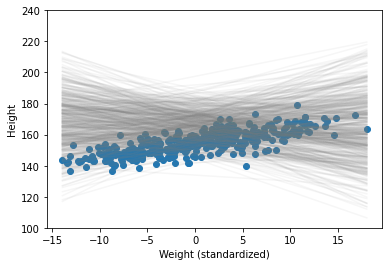

In [79]:
R = 1000
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

df = sim.draws_pd()
print(df.head())

alpha = df['alpha']
beta = df['beta']
height = df['height[1]']
weights = np.linspace(min(d.c_weight), max(d.c_weight), len(alpha))

plt.scatter(d.c_weight, d.height)
for i in range(len(alpha)):
    heights_plot = alpha[i] + beta[i] * weights
    plt.plot(weights, heights_plot, color='gray', alpha=0.07)
plt.ylim(100, 240)
plt.xlabel('Weight (standardized)')
plt.ylabel('Height')
plt.show()

### Task 5

In [87]:
%%writefile height_2b_ppc.stan

data {
   int N;
   real weight[N];
}

generated quantities {
   real sigma = cauchy_rng(0, 10);
   real alpha = normal_rng(165, 10);
   real beta = lognormal_rng(0, 1);

   real height[N];
   for (i in 1:N) {
      height[i] = normal_rng(alpha + beta * weight[i], sigma);
  }
}

Overwriting height_2b_ppc.stan


INFO:cmdstanpy:compiling stan file /height_2b_ppc.stan to exe file /height_2b_ppc
INFO:cmdstanpy:compiled model executable: /height_2b_ppc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/height_2b_ppc.hpp /height_2b_ppc.stan
Warning in '/height_2b_ppc.stan', line 4, column 3: Declaration of arrays by
    placing brackets after a variable name is deprecated and will be removed
    in Stan 2.32.0. Instead use the array keyword before the type. This can
    be changed automatically using the auto-format flag to stanc
Warning in '/height_2b_ppc.stan', line 12, column 3: Declaration of arrays by
    placing brackets after a variable name is deprecated and will be removed
    in Stan 2.32.0. Instead use the array keyword before the type. This can
    be changed automatically using the auto-format flag to stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 


INFO:cmdstanpy:CmdStan done processing.



   lp__  accept_stat__    sigma    alpha      beta  height[1]  height[2]  \
0   0.0            0.0   0.0000    0.000  0.000000      0.000      0.000   
1   0.0            0.0   0.0000    0.000  0.000000      0.000      0.000   
2   0.0            0.0   0.0000    0.000  0.000000      0.000      0.000   
3   0.0            0.0   0.0000    0.000  0.000000      0.000      0.000   
4   0.0            0.0  12.1068  170.989  0.978216    217.268    197.879   

   height[3]  height[4]  height[5]  ...  height[41]  height[42]  height[43]  \
0      0.000      0.000      0.000  ...       0.000       0.000       0.000   
1      0.000      0.000      0.000  ...       0.000       0.000       0.000   
2      0.000      0.000      0.000  ...       0.000       0.000       0.000   
3      0.000      0.000      0.000  ...       0.000       0.000       0.000   
4    198.891    223.401    201.655  ...     234.667     212.997     228.067   

   height[44]  height[45]  height[46]  height[47]  height[48]  heig

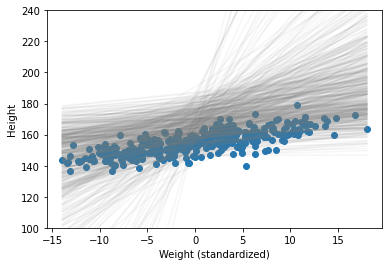

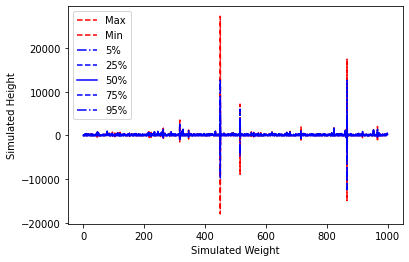

In [88]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)


df = sim.draws_pd()
print(df.head())

alpha = df['alpha']
beta = df['beta']
height = df['height[1]']
weights = np.linspace(min(d.c_weight), max(d.c_weight), len(alpha))

plt.scatter(d.c_weight, d.height)
for i in range(len(alpha)):
    heights_plot = alpha[i] + beta[i] * weights
    plt.plot(weights, heights_plot, color='gray', alpha=0.07)
plt.ylim(100, 240)
plt.xlabel('Weight (standardized)')
plt.ylabel('Height')
plt.show()

# For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?
heights = sim.draws_pd().loc[:, 'height[1]':'height[50]'].values
# Calculate summary statistics for each simulated weight
heights_max = np.max(heights, axis=1)
heights_min = np.min(heights, axis=1)
heights_q5 = np.quantile(heights, 0.05, axis=1)
heights_q25 = np.quantile(heights, 0.25, axis=1)
heights_q50 = np.quantile(heights, 0.50, axis=1)
heights_q75 = np.quantile(heights, 0.75, axis=1)
heights_q95 = np.quantile(heights, 0.95, axis=1)
# Plot the summary statistics for each simulated weight
fig, ax = plt.subplots()
ax.plot(heights_max, 'r--', label='Max')
ax.plot(heights_min, 'r--', label='Min')
ax.plot(heights_q5, 'b-.', label='5%')
ax.plot(heights_q25, 'b--', label='25%')
ax.plot(heights_q50, 'b', label='50%')
ax.plot(heights_q75, 'b--', label='75%')
ax.plot(heights_q95, 'b-.', label='95%')
ax.legend()
ax.set_xlabel('Simulated Weight')
ax.set_ylabel('Simulated Height')
plt.show()

### Task 6

In [94]:
%%writefile height_2_fit.stan

data {
  int<lower=0> N;
  real heights[N];
  real weights[N];
}

parameters {
  real<lower=0> alpha;
  real<lower=0> beta;
  real<lower=0> sigma;
}

transformed parameters {
  real<lower=0> mean[N];
  for (i in 1:N) {
    mean[i] = alpha + beta * weights[i];
  }
}

model {
  alpha ~ normal(165, 10);
  beta ~ normal(0, 1);
  sigma ~ cauchy(0, 10);
    
  for (i in 1:N) {
    heights[i] ~ normal(mean[i], sigma);
  }
}

generated quantities {
  real height[N];
  for (i in 1:N) {
    height[i] = normal_rng(mean[i], sigma);
  }
}


Overwriting height_2_fit.stan


In [95]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')
N = 50
data_fit = {'N': N, 'weights': d.weight.values[:N], 'heights': d.height.values[:N]}
fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:compiling stan file /height_2_fit.stan to exe file /height_2_fit
INFO:cmdstanpy:compiled model executable: /height_2_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/height_2_fit.hpp /height_2_fit.stan
Warning in '/height_2_fit.stan', line 4, column 2: Declaration of arrays by
    placing brackets after a variable name is deprecated and will be removed
    in Stan 2.32.0. Instead use the array keyword before the type. This can
    be changed automatically using the auto-format flag to stanc
Warning in '/height_2_fit.stan', line 5, column 2: Declaration of arrays by
    placing brackets after a variable name is deprecated and will be removed
    in Stan 2.32.0. Instead use the array keyword before the type. This can
    be changed automatically using the auto-format flag to stanc
Warning in '/height_2_fit.stan', line 15, column 2: Declaration of arrays by
    placing brackets after a variable name is deprecated and will be removed
    in Stan 2.32.0. Instead


INFO:cmdstanpy:CmdStan done processing.


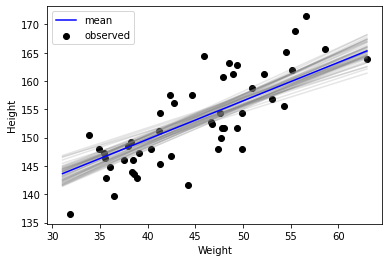

In [96]:
alpha_sim = fit.draws_pd()['alpha']
beta_sim = fit.draws_pd()['beta']
weights = np.linspace(d.weight.min(), d.weight.max(), 50)

# Plot lines for each slope
for i in range(50):
    alpha_i = alpha_sim[i]
    beta_i = beta_sim[i]
    heights_i = alpha_i + beta_i * weights
    plt.plot(weights, heights_i, color='gray', alpha=0.2)
    
# Plot mean line for alpha and beta
alpha_mean = alpha_sim.mean()
beta_mean = beta_sim.mean()
heights_mean = alpha_mean + beta_mean * weights
plt.plot(weights, heights_mean, color='blue', label='mean')
plt.scatter(d.weight[:N], d.height[:N], color='black', label='observed')
plt.legend()
plt.xlabel('Weight')
plt.ylabel('Height')
plt.show()

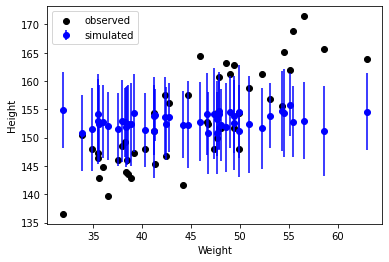

In [97]:
# Calculate mean and standard deviation of height for each weight value
heights_sim = fit.draws_pd().loc[:, 'height[1]':'height[50]'].values
heights_mean = heights_sim.mean(axis=1)[:N]
heights_std = heights_sim.std(axis=1)[:N]

# Plot 
plt.errorbar(d.weight.values[:N], heights_mean, yerr=heights_std, fmt='o', color='blue', label='simulated')
plt.scatter(d.weight[:N], d.height[:N], color='black', label='observed')
plt.legend()
plt.xlabel('Weight')
plt.ylabel('Height')
plt.show()

### Task 7

In [ ]:
%%writefile height_3_fit.stan

data {
  int<lower=0> N;
  real heights[N];
  real weights_centered[N];
}

parameters {
  real<lower=0> alpha;
  real<lower=0> beta;
  real<lower=0> beta_2;
  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mean;
  for (i in 1:N) {
    mean[i] = alpha + beta * weights_centered[i] + beta_2  * pow(weights_centered[i], 2);
  }
}

model {
  alpha ~ normal(165, 10);
  beta ~ lognormal(0, 1);
  beta_2 ~ normal(0, 1);
  sigma ~ cauchy(0, 10);
  
  heights ~ normal(mean, sigma);
}

generated quantities {
  real height[N];
  for (i in 1:N) {
    height[i] = normal_rng(mean[i], sigma);
  }
}


Overwriting height_3_fit.stan


INFO:cmdstanpy:compiling stan file /height_3_fit.stan to exe file /height_3_fit
INFO:cmdstanpy:compiled model executable: /height_3_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/height_3_fit.hpp /height_3_fit.stan
Warning in '/height_3_fit.stan', line 4, column 2: Declaration of arrays by
    placing brackets after a variable name is deprecated and will be removed
    in Stan 2.32.0. Instead use the array keyword before the type. This can
    be changed automatically using the auto-format flag to stanc
Warning in '/height_3_fit.stan', line 5, column 2: Declaration of arrays by
    placing brackets after a variable name is deprecated and will be removed
    in Stan 2.32.0. Instead use the array keyword before the type. This can
    be changed automatically using the auto-format flag to stanc
Warning in '/height_3_fit.stan', line 32, column 2: Declaration of arrays by
    placing brackets after a variable name is deprecated and will be removed
    in Stan 2.32.0. Instead


INFO:cmdstanpy:CmdStan done processing.


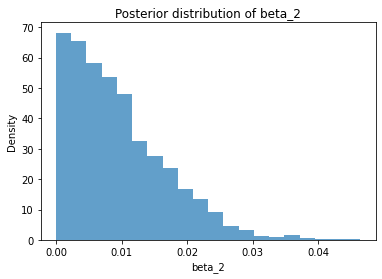

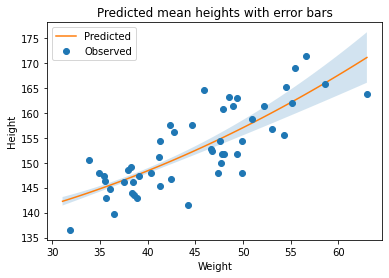

In [ ]:
N = 50
model_3_fit=CmdStanModel(stan_file='height_3_fit.stan')
weights_centered = d.weight.values[:N] - d.weight.values[:N].mean()
data_centered = {'N': N, 'weights_centered': weights_centered, 'heights': d.height.values[:N]}
fit=model_3_fit.sample(data=data_centered,seed=28052020)

beta_2_sim = fit.draws_pd()['beta_2']
plt.hist(beta_2_sim, density=True, bins=20, alpha=0.7)
plt.xlabel('beta_2')
plt.ylabel('Density')
plt.title('Posterior distribution of beta_2')
plt.show()

# Plot the predicted mean heights and compare with the observed data
weights_test = np.linspace(d.weight.min(), d.weight.max(), 100)
weights_test_centered = weights_test - d.weight.values[:N].mean()

# Calculate the predicted mean heights for the test weights
beta_2_draws = fit.draws_pd()['beta_2']
mean_test = np.mean(fit.draws_pd()['alpha']) + np.mean(fit.draws_pd()['beta']) * weights_test_centered + np.mean(beta_2_draws) * weights_test_centered ** 2

# Calculate the one standard deviation error bars for the predicted mean heights
std_test = np.std(fit.draws_pd()['alpha']) + np.std(fit.draws_pd()['beta']) * weights_test_centered + np.std(beta_2_draws) * weights_test_centered ** 2
upper_test = mean_test + std_test
lower_test = mean_test - std_test

# Plot the predicted mean heights and error bars along with the observed data
plt.errorbar(d.weight.values[:N], d.height.values[:N], fmt='o', label='Observed')
plt.plot(weights_test, mean_test, label='Predicted')
plt.fill_between(weights_test, lower_test, upper_test, alpha=0.2)
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Predicted mean heights with error bars')
plt.legend()
plt.show()